In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, ReLU
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import optimizers, layers
from scipy import integrate

import warnings
warnings.filterwarnings('ignore')

## Main driver functions

In [2]:
# Initialize number of nodes in the hidden layer
H =  5

In [3]:
def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]

def rexp():
    return -tf.math.log(runif())

@tf.function
def inverse(x, w, b, v):
  tf.debugging.assert_equal(b[0],tf.zeros([1,],dtype=tf.float64))
  w = tf.cast(w, dtype=tf.float64)
  b = tf.cast(b, dtype=tf.float64)
  v = tf.cast(v, dtype=tf.float64)
  # Calculate v0
  if w.get_shape() != v.get_shape():
    v0 = -(tf.reshape(b,[1,H]) @ v)[0]
  x = tf.dtypes.cast(x, tf.float64)
  # num_layer = w.shape[1]

  b_over_w = - b / w # the negative sign is important
  b_over_w = tf.reshape(b_over_w, [-1])# change it to row vector
  # Then we need to compute range for the inverse function
  r_x = tf.reshape(
      [tf.matmul( ( tf.nn.relu(w * b_over_w[i] + b) ), v) + v0 for i in range(1)], 
      [-1]
      )
  
  # pad r_x with 0 and inf
  # right side gives us the right index
  zero = tf.constant([0.], dtype=tf.float64)
  pos = tf.searchsorted(tf.sort(tf.concat([zero, r_x, [np.inf]],0)), x,side='right') # get the interval index
  # tf.print('pos',pos)
  pos = tf.reshape(pos,[]) # get only numerical value
  # change it to row vector
  v = tf.reshape(v, [-1])
  w = tf.reshape(w, [-1])
  
  index = tf.argsort(r_x)
  # sort according to the index
  v_b = tf.gather(v * b, index)
  v_w = tf.gather(v * w, index)

  num = x - v0 - tf.reduce_sum(v_b[:(pos - 1)])
  deo = tf.reduce_sum(v_w[:(pos - 1)])

  with tf.control_dependencies([
      tf.debugging.assert_positive(num, message='inverse num'),
      tf.debugging.assert_positive(deo, message='inverse deo'),
  ]):
    return tf.math.divide_no_nan(num, deo)[0]

@tf.function
def gen_gaps(w, b, v, k: int,  
             theta=tf.constant(1e-4, dtype=tf.float64), 
             rho=tf.constant(1e-5, dtype=tf.float64)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    # b = tf.math.exp(b)
    # Add a zero at the begging of b
    if b.get_shape() == H - 1:
      if b.dtype == tf.float32:
        b = tf.concat([tf.zeros([1,],dtype='float32'),b],axis=0)
      else:
        b = tf.concat([tf.zeros([1,],dtype='float64'),b],axis=0)

    if b.dtype == tf.float32:
      tf.debugging.assert_equal(b[0],tf.zeros([1,],dtype='float32'))
    else: 
      tf.debugging.assert_equal(b[0],tf.zeros([1,],dtype='float64'))

    w = tf.cast(w, dtype=tf.float64)
    b = tf.cast(b, dtype=tf.float64)
    v = tf.cast(v, dtype=tf.float64)
    # first b is always 0
    if w.get_shape() != v.get_shape():
      v0 = -(tf.reshape(b,[1,H]) @ v)[0]
    # print(v0)
    z = tf.convert_to_tensor([[rexp()]])
    x = inverse(z, w, b, v)[0]  # initialize x by sampling from prior
    tf.debugging.assert_positive(x, message='gen_gaps first x')
    # print('first x passed')
    pos = tf.constant(0., dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 2)
    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = v0 + tf.nn.relu(w * u_x + b) @ v # compute R(u_x)

        x = inverse((z + r_u_x), w, b, v)[0]  # segment height
        with tf.control_dependencies(
            [tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          pos += rexp() / (x * (theta + rho))  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            pos += rexp() / (x * (theta + rho))  # length to next event
    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gen_gaps diff')
    ]):
        return tf.cast(diff, tf.float64)

In [4]:
def relu(x):
  return np.maximum(0,x)
def SSE(x):
  weights = generator.get_weights()
  w = weights[0]
  b = weights[1]
  b = np.concatenate((np.array([0.]),b))
  v = weights[2]
  v0 = -(b.reshape((1,H)) @ v)[0]
  r_hat = v0 + relu(w * x + b) @ v

  w = np.array([[1.]])
  b = np.array([0.])
  v = np.array([[1.]])
  v0 = np.array([0.])
  r = v0 + relu(w * x + b) @ v

  return np.power(r_hat.reshape(-1) - r.reshape(-1),2) * np.exp(-x)

## real R

In [5]:
w = tf.constant([[1.]], dtype=tf.float64)
b = tf.constant([0.], dtype=tf.float64)
v = tf.constant([[1.]], dtype=tf.float64)
v0 = tf.constant([0.], dtype=tf.float64)
def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]

def rexp():
    return -tf.math.log(runif())

@tf.function
def inverse_real(x, w, b, v):
  H = 1
  # Calculate v0
  w = tf.cast(w, dtype=tf.float64)
  b = tf.cast(b, dtype=tf.float64)
  v = tf.cast(v, dtype=tf.float64)
  v0 = -(tf.reshape(b,[1,H])@v)[0]
  # print(v0)
  x = tf.dtypes.cast(x, tf.float64)
  num_layer = w.shape[1]

  b_over_w = - b / w # the negative sign is important
  b_over_w = tf.reshape(b_over_w, [-1])# change it to row vector
  # Then we need to compute range for the inverse function
  r_x = tf.reshape(
      [tf.matmul( ( tf.nn.relu(w * b_over_w[i] + b) ), v) + v0 for i in range(1)], 
      [-1]
      )
  
  # pad r_x with 0 and inf
  # right side gives us the right index
  zero = tf.constant([0.], dtype=tf.float64)
  pos = tf.searchsorted(tf.sort(tf.concat([zero, r_x, [np.inf]],0)), x,side='right') # get the interval index
  # tf.print('pos',pos)
  pos = tf.reshape(pos,[]) # get only numerical value
  # change it to row vector
  v = tf.reshape(v, [-1])
  w = tf.reshape(w, [-1])
  
  index = tf.argsort(r_x)
  # sort according to the index
  v_b = tf.gather(v * b, index)
  v_w = tf.gather(v * w, index)

  num = x - v0 - tf.reduce_sum(v_b[:(pos - 1)])
  deo = tf.reduce_sum(v_w[:(pos - 1)])

  with tf.control_dependencies([
      tf.debugging.assert_positive(num, message='inverse num'),
      tf.debugging.assert_positive(deo, message='inverse deo'),
  ]):
    return tf.math.divide_no_nan(num, deo)[0]

@tf.function
def gen_gaps_real(w, b, v, k: int,  
             theta=tf.constant(1e-4, dtype=tf.float64), 
             rho=tf.constant(1e-5, dtype=tf.float64)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    H = 1
    w = tf.cast(w, dtype=tf.float64)
    b = tf.cast(b, dtype=tf.float64)
    v = tf.cast(v, dtype=tf.float64)
    v0 = -(tf.reshape(b,[1,H])@v)[0]
    # print(v0)
    z = tf.convert_to_tensor([[rexp()]])
    x = inverse_real(z, w, b, v)[0]  # initialize x by sampling from prior
    tf.debugging.assert_positive(x, message='gen_gaps first x')
    # print('first x passed')
    pos = tf.constant(0., dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 2)
    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = v0 + tf.nn.relu(w * u_x + b) @ v # compute R(u_x)

        x = inverse_real((z + r_u_x), w, b, v)[0]  # segment height
        with tf.control_dependencies(
            [tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          pos += rexp() / (x * (theta + rho))  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            pos += rexp() / (x * (theta + rho))  # length to next event
    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gen_gaps diff')
    ]):
        return tf.cast(diff, tf.float64)

gen_gaps_real(w,b,v,10)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([3.16550445e+03, 5.19243844e+03, 4.67619987e+03, 9.12296898e+03,
       1.53159145e+03, 3.65071515e+04, 5.15099725e+02, 2.28968565e+04,
       2.71286772e+03, 1.68593415e+01])>

## Generator


In [6]:
class CustomGenGaps(keras.layers.Layer):
  ''' Take one parameter H as input 
      Then construct one hidden layer with H units'''
  def __init__(self, H, name='gen_gaps_layer'):
      super(CustomGenGaps, self,).__init__(name=name)
      w_init = tf.random_normal_initializer(mean=0.5)
      b_init = tf.random_normal_initializer(mean=0.1)
      self.lr = 0.15
      self.w = self.add_weight(shape=(1,H), initializer=w_init,dtype='float32',
                               trainable=True, constraint=tf.keras.constraints.NonNeg(), 
                               regularizer=tf.keras.regularizers.l1_l2(l1=self.lr,l2=self.lr))
      self.b = self.add_weight(shape=(H-1,), initializer=b_init,dtype='float32',
                               trainable=True, constraint=tf.keras.constraints.NonNeg(),
                               regularizer=tf.keras.regularizers.l1_l2(l1=self.lr,l2=self.lr))
      self.v = self.add_weight(shape=(H,1), initializer=w_init,dtype='float32',
                               trainable=True,constraint=tf.keras.constraints.NonNeg(),
                               regularizer=tf.keras.regularizers.l1_l2(l1=self.lr,l2=self.lr))

      # self.w = tf.Variable(initial_value=w_init(shape=(1,H), dtype='float64'), trainable=True)
      # self.b = tf.Variable(initial_value=b_init(shape=(H - 1,), dtype='float64'),trainable=True)
      # self.v = tf.Variable(initial_value=w_init(shape=(H,1), dtype='float64'), trainable=True)
      # self.v0 = tf.Variable(initial_value=b_init(shape=(1,), dtype='float64'), trainable=True)

  def call(self,length):
      return tf.reshape(gen_gaps(self.w,self.b,self.v,length),[1,length])

class Generator(keras.Model):
  ''' wrap the GenGaps layer into Keras Model '''
  def __init__(self, H):
    super(Generator, self).__init__()
    self.GenLayer = CustomGenGaps(H)

  def call(self, inputs, training=True):
    return self.GenLayer(inputs)

generator = Generator(H)
generator(10)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[ 237.66405452,   54.95523985,  204.20288296,  363.19070252,
         745.05313865,  796.32448093, 1442.05347096, 1429.07052407,
         569.00719568,  923.25523934]])>

Objective funtion

In [7]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_gaps_layer (CustomGenGap multiple                  14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [8]:
generator.get_weights()

[array([[0.47174266, 0.54932404, 0.38473895, 0.43621713, 0.55862033]],
       dtype=float32),
 array([0.07089524, 0.05032164, 0.06327514, 0.09234841], dtype=float32),
 array([[0.47642422],
        [0.4555958 ],
        [0.46550146],
        [0.54461133],
        [0.48573086]], dtype=float32)]

In [9]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Comparison between real and fake *R( )*

The code below works fine on "Real R" 

In [10]:
def performance_check(generator):
  # Real Generator Plot
  w = tf.constant([[1.]], dtype=tf.float64)
  b = tf.constant([0.], dtype=tf.float64)
  v = tf.constant([[1.]], dtype=tf.float64)
  v0 = tf.constant([0.], dtype=tf.float64)
  x = np.array([np.array([[i]]) for i in range(-10,100)])
  y = np.array([v0 + tf.nn.relu(w * i + b) @ v for i in x])
  plt.plot(x.reshape((-1,)),y.reshape((-1,)),label = 'true')
  # Plot fake R
  weights = generator.get_weights()
  w = weights[0]
  b = weights[1]
  b = tf.concat([tf.zeros([1,],dtype='float64'),b],axis=0)
  v = weights[2]
  v0 = -(tf.reshape(b,[1,H]) @ v)[0]
  r_hat = lambda x : v0 + relu(w * x + b) @ v
  y = r_hat(x)
  print('SSE:',integrate.quad(SSE, 0, np.inf)[0])
  plt.plot(x.reshape((-1,)),tf.reshape(y,[-1]),label = 'false')
  plt.legend()
  plt.show()

SSE: 0.053153532286714475


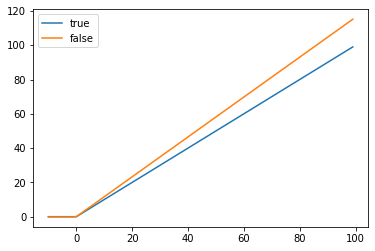

In [11]:
performance_check(generator)

## discriminator

In [12]:
discriminator = Sequential(
    [
     Input(shape=(10,)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(1)
    ],
    name="discriminator",
)


objective function

In [13]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.8):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [14]:
generator_optimizer = tf.keras.optimizers.RMSprop(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

## Define trining_step

In [15]:
  @tf.function
def training_step(generator, discriminator, k):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            g_z = tf.math.log(generator(10)) / 10
            d_x_true = discriminator(tf.math.log(tf.reshape(gen_gaps_real(w,b,v,10), (1,10))) / 10)
            d_x_fake = discriminator(g_z)

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # d_loss.append(discriminator_loss)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [16]:
def training(epoches):
  for epoch in range(epoches):
    training_step(generator, discriminator ,100)
    mse.append(integrate.quad(SSE, 0, np.inf)[0])
    if (epoch % 50) == 0: 
      print('epoch', epoch)
      performance_check(generator)
      # plt.plot(range(len(d_loss)),d_loss)

epoch 0
SSE: 0.060065454619993054


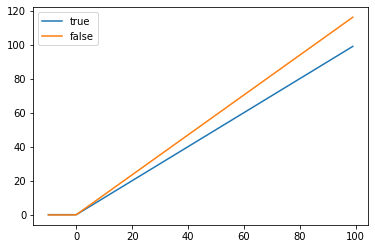

epoch 50
SSE: 0.014675737965348684


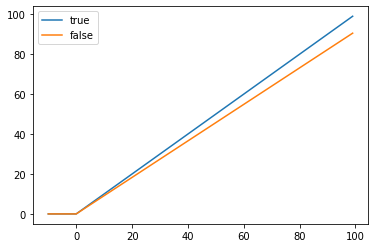

epoch 100
SSE: 2.0187649062397663


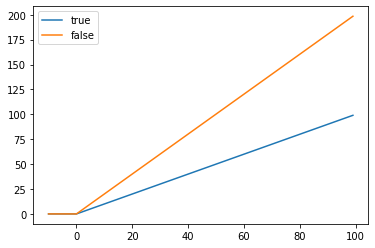

epoch 150
SSE: 0.7061868963143451


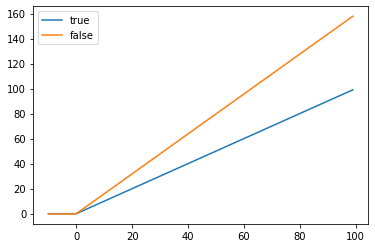

epoch 200
SSE: 0.7606320961185912


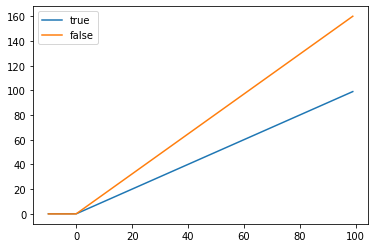

epoch 250
SSE: 0.7953032338923806


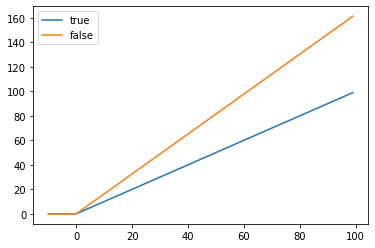

epoch 300
SSE: 0.6783460723220799


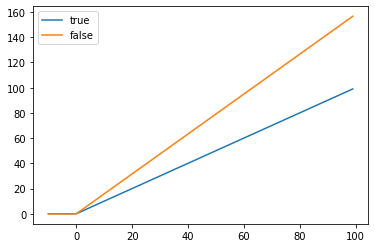

epoch 350
SSE: 0.6109660451117294


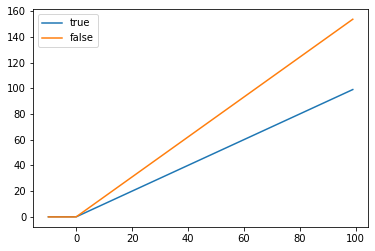

epoch 400
SSE: 0.40411777376249214


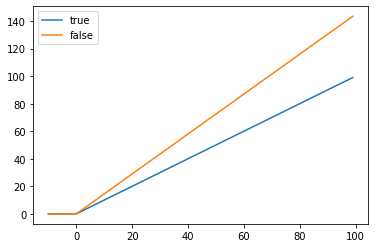

epoch 450
SSE: 0.2270733023178984


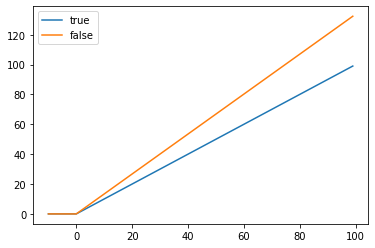

epoch 500
SSE: 0.19020182767142105


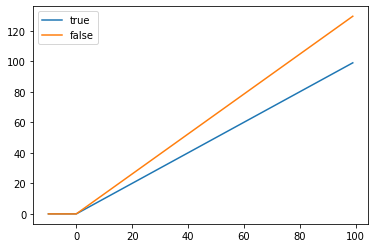

epoch 550
SSE: 0.07921499514113764


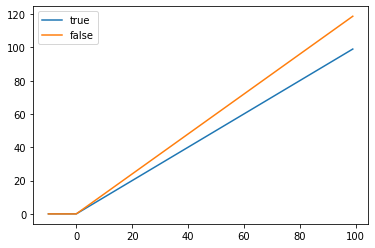

epoch 600
SSE: 0.028340520374189163


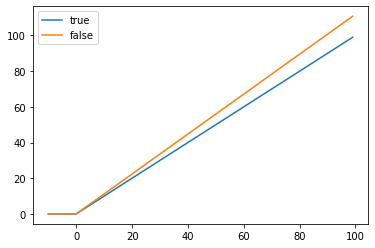

epoch 650
SSE: 0.009828235399640799


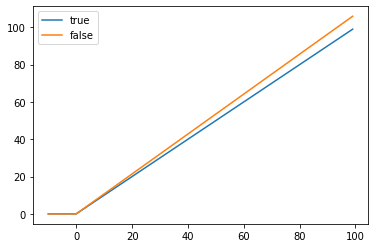

epoch 700
SSE: 0.0034700565273454147


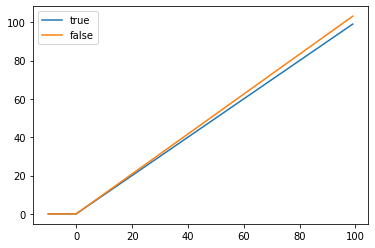

epoch 750
SSE: 0.02228760106249078


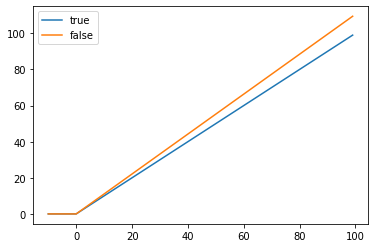

epoch 800
SSE: 0.001397620620383243


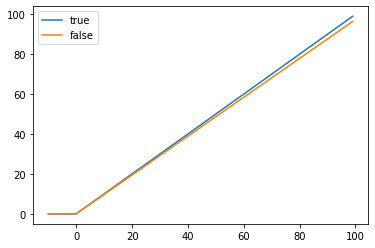

epoch 850
SSE: 0.048767262892130916


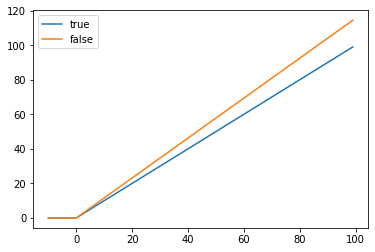

epoch 900
SSE: 0.005012348323663132


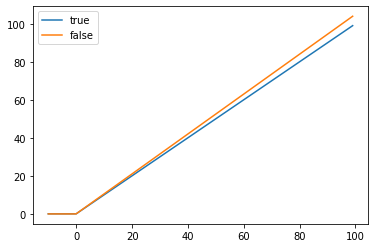

epoch 950
SSE: 0.055008812466877346


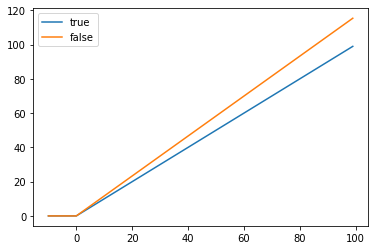

CPU times: user 16min 4s, sys: 26 s, total: 16min 30s
Wall time: 11min 59s


In [17]:
%%time
mse = []
EPOCHES = 1000
training(EPOCHES)

In [18]:
generator.weights

[<tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
 array([[1.0401528 , 0.311165  , 0.12504907, 0.12279078, 0.29124078]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0.00370044, 0.0036643 , 0.00358558, 0.00369861], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
 array([[1.0448605 ],
        [0.08930872],
        [0.10244723],
        [0.13548195],
        [0.08999705]], dtype=float32)>]

minimum SSE: 8.432875788070411e-09 appears at 768 epoch


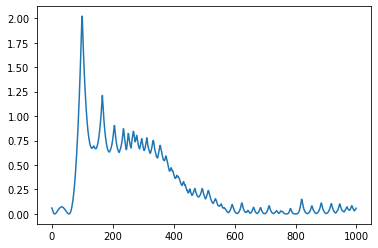

In [29]:
print('minimum SSE:',min(mse),'appears at',np.argmin(mse),'epoch')
plt.plot(range(len(mse)),mse)
plt.show()